# 04-2 BERT와 전이 학습

*이 노트북은 코랩의 A100 GPU 런타임으로 테스트했습니다.*

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/04-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

04-1절에서 정의한 `transformer_encoder()` 함수를 재사용합니다.

In [2]:
# x는 토큰 임베딩과 위치 임베딩을 더한 값입니다.
def transformer_encoder(x, padding_mask, dropout, activation='relu'):
    residual = x
    key_dim = embed_dim // num_heads
    # 멀티 헤드 어텐션을 통과합니다.
    x = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)(
        query=x, value=x, attention_mask=padding_mask)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    residual = x
    # 위치별 피드 포워드 네트워크
    x = layers.Dense(embed_dim * 4, activation=activation)(x)
    x = layers.Dense(embed_dim)(x)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    return x

## BERT

In [3]:
!pip install keras-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.2/572.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 110.2 MB/s eta 0:00:00


In [4]:
import keras_nlp

# BERT 베이스
vocab_size = 30522
num_layers = 12
num_heads = 12
embed_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

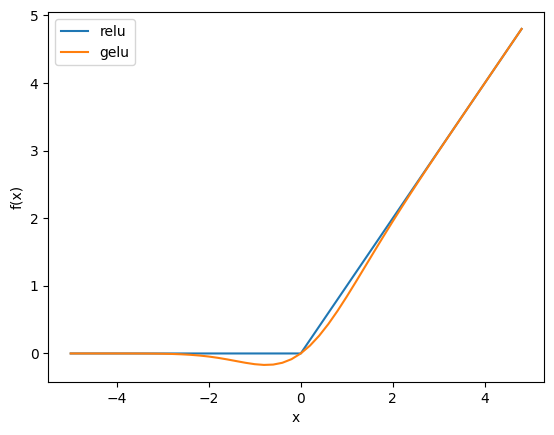

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf

def gelu(x):
    cdf = 0.5 * (1.0 + erf(x / np.sqrt(2.0)))
    return x * cdf

x = np.arange(-5, 5, 0.2)

plt.plot(x, x.clip(0), label='relu')
plt.plot(x, gelu(x), label='gelu')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [6]:
import keras
from keras import layers

In [7]:
token_ids = keras.Input(shape=(None,))
segment_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

token_embedding = layers.Embedding(vocab_size, embed_dim)(token_ids)
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)
seg_embedding = layers.Embedding(2, embed_dim)(segment_ids)

x = layers.Add()((token_embedding, pos_embedding, seg_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)

outputs = layers.Dense(embed_dim, activation='tanh')(x[:,0,:])
model = keras.Model(inputs=(token_ids, segment_ids, padding_mask),
                    outputs=(outputs))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 768)      │     23,440,896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding        │ (None, None, 768)      │        393,216 │ embedding[0][0]        │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 768)      │          1,536 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, None, 768)      │              0 │ embedding[0][0],       │
│                           │                        │                │ position_embedding[0]… │
│                           │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, None, 768)      │          1,536 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, None, 768)      │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, None, 768)      │      2,362,368 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ dropout[0][0],         │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, None, 768)      │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, None, 768)      │              0 │ dropout_2[0][0],       │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, None, 768)      │          1,536 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 3072)     │      2,362,368 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)      

 Total params: 109,482,240 (417.64 MB)

 Trainable params: 109,482,240 (417.64 MB)

 Non-trainable params: 0 (0.00 B)

## KerasNLP를 사용한 전이 학습

In [8]:
!gdown 15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
!tar -xzf aclImdb_v1.tar.gz
# 비지도 학습에 사용하는 데이터는 삭제합니다.
!rm -r aclImdb/train/unsup

Downloading...
From (original): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
From (redirected): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t&confirm=t&uuid=2fdc81b4-81d7-4f11-9b62-345ca5b739a1
To: /content/aclImdb_v1.tar.gz
100% 84.1M/84.1M [00:00<00:00, 191MB/s]


In [9]:
train_ds, val_ds = keras.utils.text_dataset_from_directory('aclImdb/train',
                                                           subset='both',
                                                           validation_split=0.2,
                                                           seed=42)
test_ds = keras.utils.text_dataset_from_directory('aclImdb/test')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [10]:
feature, target = train_ds.unbatch().take(1).get_single_element()
print(feature.numpy()[:100])
print(target.numpy())

b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell '
0


In [11]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=2
)

100%|██████████| 139/139 [00:00<00:00, 188kB/s]


100%|██████████| 507/507 [00:00<00:00, 600kB/s]


100%|██████████| 16.8M/16.8M [00:02<00:00, 5.88MB/s]


100%|██████████| 547/547 [00:00<00:00, 658kB/s]


100%|██████████| 226k/226k [00:00<00:00, 279kB/s]


In [12]:
classifier.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 128)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │             258 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
classifier.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - loss: 0.5795 - sparse_categorical_accuracy: 0.6734 - val_loss: 0.3485 - val_sparse_categorical_accuracy: 0.8464
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.3145 - sparse_categorical_accuracy: 0.8723 - val_loss: 0.2930 - val_sparse_categorical_accuracy: 0.8822
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2454 - sparse_categorical_accuracy: 0.9047 - val_loss: 0.2924 - val_sparse_categorical_accuracy: 0.8858
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1894 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.3020 - val_sparse_categorical_accuracy: 0.8832
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1374 - sparse_categorical_accuracy: 0.9532 - val_loss: 0.3566 - val_sparse_categorical_accuracy: 0.8780


In [14]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=1,
    activation='sigmoid'
)

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001)
classifier.compile(loss='binary_crossentropy',
                   optimizer=rmsprop,
                   metrics=["accuracy"])


early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
hist = classifier.fit(train_ds, validation_data=val_ds, epochs=10,
                      callbacks=[early_stopping_cb])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 111ms/step - accuracy: 0.6353 - loss: 0.6096 - val_accuracy: 0.7594 - val_loss: 0.5227
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.7959 - loss: 0.4633 - val_accuracy: 0.8274 - val_loss: 0.4104
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.8355 - loss: 0.3979 - val_accuracy: 0.8384 - val_loss: 0.4237
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.8511 - loss: 0.3687 - val_accuracy: 0.8576 - val_loss: 0.3461
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8708 - loss: 0.3238 - val_accuracy: 0.8708 - val_loss: 0.3023
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.8928 - loss: 0.2688 - val_accuracy: 0.8764 - val_loss: 0.3305
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 69ms/step - accuracy: 0.9114 - loss: 0.2389 - val_accuracy: 0.8804 - val_loss: 0.3646


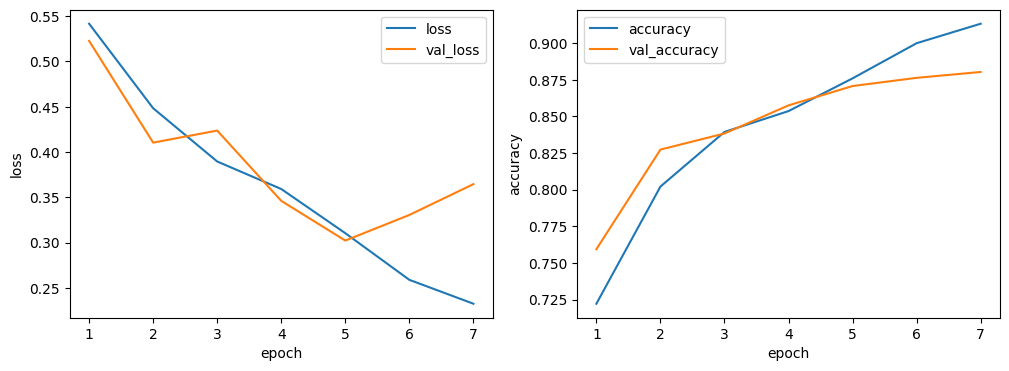

In [19]:
epochs = len(hist.history['loss'])
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, epochs+1), hist.history['loss'], label='loss')
axs[0].plot(range(1, epochs+1), hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(range(1, epochs+1))
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(range(1, epochs+1), hist.history['accuracy'], label='accuracy')
axs[1].plot(range(1, epochs+1), hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(range(1, epochs+1))
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()

In [23]:
classifier.predict([feature])

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


array([[0.25352052]], dtype=float32)

## BERT 토크나이저

In [24]:
prep_data = classifier.preprocessor(feature)
print(len(prep_data['token_ids']), prep_data['token_ids'][:10])

512 tf.Tensor([  101  1000  6090  3207 26387  1000  2003  1037  5469  3185], shape=(10,), dtype=int32)


In [25]:
prep_data['token_ids'][-10:]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [26]:
sum(prep_data['padding_mask'].numpy())

197

In [27]:
bert_tokenizer = classifier.preprocessor.tokenizer
bert_tokenizer.detokenize(prep_data['token_ids'][:10])

<tf.Tensor: shape=(), dtype=string, numpy=b'[CLS] " pandemonium " is a horror movie'>

In [28]:
tokens = []
for id in prep_data['token_ids'][:10]:
    tokens.append(bert_tokenizer.id_to_token(id))
print(tokens)

['[CLS]', '"', 'pan', '##de', '##monium', '"', 'is', 'a', 'horror', 'movie']


In [29]:
for token in tokens:
    print(bert_tokenizer.token_to_id(token), end=' ')

101 1000 6090 3207 26387 1000 2003 1037 5469 3185 

In [30]:
bert_tokenizer.tokenize('"pandemonium" is a horror movie')

<tf.Tensor: shape=(9,), dtype=int32, numpy=
array([ 1000,  6090,  3207, 26387,  1000,  2003,  1037,  5469,  3185],
      dtype=int32)>

## 허깅페이스 라이브러리를 사용한 전이 학습

In [31]:
!pip install datasets accelerate evaluate

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [1]:
from datasets import load_dataset

nsmc = load_dataset("nsmc", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for nsmc contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nsmc.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [2]:
print(nsmc)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [3]:
nsmc['train'][0]

{'id': '9976970', 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}

In [4]:
from transformers import AutoModelForSequenceClassification

bert_kor = AutoModelForSequenceClassification.from_pretrained(
    'bongsoo/bert-small-kor-v1',
    num_labels=2)

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bongsoo/bert-small-kor-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
print(bert_kor)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(10022, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-1

In [6]:
from transformers import AutoTokenizer

bert_kor_tokenizer = AutoTokenizer.from_pretrained('bongsoo/bert-small-kor-v1')

tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/70.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/226k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [7]:
prep_data = bert_kor_tokenizer(nsmc['train'][0]['document'])
prep_data.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [8]:
prep_data['input_ids']

[2, 606, 261, 1519, 17, 17, 4668, 766, 1400, 1132, 1464, 1130, 2889, 3]

In [9]:
tokens = bert_kor_tokenizer.convert_ids_to_tokens(prep_data['input_ids'])
print(tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜', '##증', '##나', '##네', '##요', '목소리', '[SEP]']


In [10]:
bert_kor_tokenizer.convert_tokens_to_string(tokens)

'[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]'

In [11]:
def tokenize(batch):
    return bert_kor_tokenizer(batch['document'], padding=True, truncation=True)

In [12]:
nsmc_tokenized = nsmc.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [13]:
print(nsmc_tokenized)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})


In [14]:
nsmc_train = nsmc_tokenized["train"].shuffle(seed=42).select(range(1000))
nsmc_test = nsmc_tokenized["test"].shuffle(seed=42).select(range(100))

In [15]:
import evaluate

metric = evaluate.load("accuracy")

In [16]:
import numpy as np

def compute_metrics(eval_pred):
    # (100, 2), (100,)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir='bert_kor_nsmc',
                                  num_train_epochs=5,
                                  eval_strategy='epoch',
                                  save_strategy='epoch',
                                  logging_steps=len(nsmc_train)//8,
                                  load_best_model_at_end=True)

trainer = Trainer(model=bert_kor,
                  train_dataset=nsmc_train,
                  eval_dataset=nsmc_test,
                  args=training_args,
                  compute_metrics=compute_metrics)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.619200,0.593797,0.700000
2,0.415600,0.493749,0.790000
3,0.271800,0.651751,0.770000
4,0.187000,0.739754,0.770000
5,0.105900,0.804438,0.780000


TrainOutput(global_step=625, training_loss=0.3199134552001953, metrics={'train_runtime': 15.721, 'train_samples_per_second': 318.046, 'train_steps_per_second': 39.756, 'total_flos': 54844270920000.0, 'train_loss': 0.3199134552001953, 'epoch': 5.0})

In [18]:
preds_output = trainer.predict(nsmc_test)

In [19]:
print(preds_output.predictions[:7])
print(preds_output.label_ids[:7])

[[ 0.9996184  -1.1901807 ]
 [-2.4450173   1.8826869 ]
 [-2.224352    1.6534423 ]
 [-1.0787973   0.590111  ]
 [ 1.2761605  -1.4698765 ]
 [ 0.92313707 -1.2446705 ]
 [-0.5959383   0.15765916]]
[0 1 1 1 0 1 0]


In [20]:
from transformers import pipeline

pipe = pipeline(task='text-classification',
                model='WhitePeak/bert-base-cased-Korean-sentiment')

config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [21]:
pipe('아 더빙.. 진짜 짜증나네요 목소리')

[{'label': 'LABEL_0', 'score': 0.997101366519928}]